# Imports

In [1]:
# import required modules
import random
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import model_selection, metrics, preprocessing
import copy

import torch
from torch import nn, optim, Tensor

from torch_sparse import SparseTensor, matmul

from collections import defaultdict

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.data import download_url, extract_zip
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj
import torch.nn.functional as F

# Load Dataset

In [2]:
# download the dataset
# https://grouplens.org/datasets/movielens/
# "Small: 100,000 ratings and 3,600 tag applications applied to 9,000 movies by 600 users. Last updated 9/2018"
url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
extract_zip(download_url(url, '.'), '.')

movie_path = './ml-latest-small/movies.csv'
rating_path = './ml-latest-small/ratings.csv'
user_path = './ml-latest-small/users.csv'

Using existing file ml-latest-small.zip
Extracting ./ml-latest-small.zip


In [3]:
# Lectura del archivo de calificaciones
rating_df = pd.read_csv(rating_path)

"""Se crean dos instancias del LabelEncoder, que es una herramienta de la biblioteca sklearn.preprocessing.
El LabelEncoder se utiliza para transformar valores no numéricos en valores numéricos.
En este caso, se tienen dos encoders, uno para usuarios (lbl_user) y otro para películas (lbl_movie)."""
lbl_user = preprocessing.LabelEncoder()
lbl_movie = preprocessing.LabelEncoder()

"""se están transformando los identificadores de usuario y película originales a valores numéricos codificados.
Esto se hace utilizando el método fit_transform de cada LabelEncoder.
Después de esta transformación, los identificadores de usuario y película en
rating_df son reemplazados por sus valores codificados."""
rating_df.userId = lbl_user.fit_transform(rating_df.userId.values)
rating_df.movieId = lbl_movie.fit_transform(rating_df.movieId.values)

In [4]:
print(rating_df.userId.max())
print(rating_df.movieId.max())

609
9723


In [5]:
# load edges between users and movies
"""Procesa las aristas entre usuarios y películas a partir de un DataFrame de
pandas que representa las interacciones entre usuarios y películas. Esta función
es útil para preparar los datos para ser alimentados a una arquitectura de grafo,
como es el caso de LightGCN en un sistema de recomendación."""
def load_edge_csv(df, 
                  src_index_col, 
                  dst_index_col,  
                  link_index_col, 
                  rating_threshold=3.5):
    """Loads csv containing edges between users and items

    Args:
        path (str): path to csv file
        src_index_col (str): column name of users
        src_mapping (dict): mapping between row number and user id
        dst_index_col (str): column name of items
        dst_mapping (dict): mapping between row number and item id
        link_index_col (str): column name of user item interaction
        rating_threshold (int, optional): Threshold to determine positivity of edge. Defaults to 4.

    Returns:
        torch.Tensor: 2 by N matrix containing the node ids of N user-item edges
    """
    
    edge_index = None
    src = [user_id for user_id in  df['userId']]
    
    num_users = len(df['userId'].unique())

    dst = [(movie_id) for movie_id in df['movieId']]
    
    link_vals = df[link_index_col].values
    
    # Se itera sobre todas las interacciones en edge_attr
    """Si la interacción es positiva (calificación por encima del umbral),
    se añade la arista correspondiente (usuario, película) a edge_index y se
    añade la calificación a edge_values"""
    edge_attr = torch.from_numpy(df[link_index_col].values).view(-1, 1).to(torch.long) >= rating_threshold

    edge_values = []

    edge_index = [[], []]
    for i in range(edge_attr.shape[0]):
        if edge_attr[i]:
            edge_index[0].append(src[i])
            edge_index[1].append(dst[i])
            edge_values.append(link_vals[i])
            
    """edge_values, que contiene las calificaciones asociadas a esas aristas."""
    # edge_values is the label we will use for compute training loss                
    return edge_index, edge_values

In [6]:
edge_index, edge_values = load_edge_csv(
    rating_df,
    src_index_col='userId',
    dst_index_col='movieId',
    link_index_col='rating',
    rating_threshold=1 # need to use threshold=1 so the model can learn based on RMSE
)

In [7]:
# Convert to tensor
# We use LongTensor here because the .propagate() method in the model needs either LongTensor or SparseTensor
"""Convierte la lista edge_index a un LongTensor de PyTorch. Se utiliza LongTensor porque es el
tipo adecuado para índices, especialmente cuando se trabaja con métodos que propagan información
a través de un grafo."""
edge_index = torch.LongTensor(edge_index)

"""Convierte la lista edge_values a un tensor estándar de PyTorch. Aquí no es necesario especificar LongTensor
porque edge_values almacena valores (calificaciones en este caso) y no índices."""
edge_values = torch.tensor(edge_values)

print(edge_index)
print(edge_index.size())

print(edge_values)
print(edge_values.size())

tensor([[   0,    0,    0,  ...,  609,  609,  609],
        [   0,    2,    5,  ..., 9444, 9445, 9485]])
torch.Size([2, 99466])
tensor([4., 4., 4.,  ..., 5., 5., 3.], dtype=torch.float64)
torch.Size([99466])


In [8]:
# split the edges of the graph using a 80/10/10 train/validation/test split
# num_users, num_movies = len(user_mapping), len(movie_mapping)

num_users = len(rating_df['userId'].unique())
num_movies = len(rating_df['movieId'].unique())

print(f"num_users {num_users}, num_movies {num_movies}")

num_users 610, num_movies 9724


In [9]:
"""La función convert_r_mat_edge_index_to_adj_mat_edge_index está diseñada para convertir una matriz
de interacción usuario-película en forma de índices de aristas a una matriz de adyacencia de forma
dispersa (COO)."""

def convert_r_mat_edge_index_to_adj_mat_edge_index(input_edge_index, input_edge_values):
    """Inicializa una matriz R con ceros de tamaño num_users x num_movies. Esta matriz representará
    las interacciones entre usuarios y películas."""
    R = torch.zeros((num_users, num_movies))
    
    for i in range(len(input_edge_index[0])):
        row_idx = input_edge_index[0][i]
        col_idx = input_edge_index[1][i]
        R[row_idx][col_idx] = input_edge_values[i] # assign actual edge value to Interaction Matrix

    R_transpose = torch.transpose(R, 0, 1)
    
    """Inicializa una matriz de adyacencia con ceros de tamaño (num_users + num_movies) x (num_users + num_movies).
    Esta matriz representará las relaciones entre todos los nodos (tanto usuarios como películas).
    La primera mitad de las filas representará a los usuarios, y la segunda mitad a las películas."""
    adj_mat = torch.zeros((num_users + num_movies , num_users + num_movies))
    adj_mat[: num_users, num_users :] = R.clone()
    adj_mat[num_users :, : num_users] = R_transpose.clone()
    
    """Se convierte la matriz de adyacencia adj_mat a formato COO, que es una representación dispersa."""
    adj_mat_coo = adj_mat.to_sparse_coo()
    adj_mat_coo_indices = adj_mat_coo.indices()
    adj_mat_coo_values = adj_mat_coo.values()
    return adj_mat_coo_indices, adj_mat_coo_values

In [10]:
def convert_adj_mat_edge_index_to_r_mat_edge_index(input_edge_index, input_edge_values):
    """Se convierten los índices de aristas de entrada y los valores asociados a un formato SparseTensor
    utilizando la biblioteca de PyTorch. Esta es una estructura de datos que representa matrices dispersas.
    Los índices de las aristas y los valores son utilizados como las filas,
    columnas y valores respectivos del tensor disperso"""
    sparse_input_edge_index = SparseTensor(row=input_edge_index[0], 
                                           col=input_edge_index[1], 
                                           value = input_edge_values,
                                           sparse_sizes=((num_users + num_movies), num_users + num_movies))
    
    """Esto facilita la extracción de la submatriz que representa las interacciones usuario-película."""
    adj_mat = sparse_input_edge_index.to_dense()
    
    """A partir de la matriz de adyacencia densa, se extrae la submatriz de interacción usuario-película."""
    interact_mat = adj_mat[: num_users, num_users :]
    
    """Se convierte la matriz de interacción densa a formato COO para obtener los índices de
    las aristas y sus valores correspondientes."""
    r_mat_edge_index = interact_mat.to_sparse_coo().indices()
    r_mat_edge_values = interact_mat.to_sparse_coo().values()
    
    return r_mat_edge_index, r_mat_edge_values

In [11]:
num_interactions = edge_index.shape[1]
all_indices = [i for i in range(num_interactions)]

train_indices, test_indices = train_test_split(all_indices, 
                                               test_size=0.2, 
                                               random_state=1)

val_indices, test_indices = train_test_split(test_indices, 
                                             test_size=0.5, 
                                             random_state=1)

In [12]:
train_edge_index = edge_index[:, train_indices]
train_edge_value = edge_values[train_indices]

val_edge_index = edge_index[:, val_indices]
val_edge_value = edge_values[val_indices]

test_edge_index = edge_index[:, test_indices]
test_edge_value = edge_values[test_indices]

In [13]:
print(f"num_users {num_users}, num_movies {num_movies}, num_interactions {num_interactions}")
print(f"train_edge_index {train_edge_index}")
print((num_users + num_movies))
print(torch.unique(train_edge_index[0]).size())
print(torch.unique(train_edge_index[1]).size())

print(test_edge_value)
print(test_edge_value.size())

num_users 610, num_movies 9724, num_interactions 99466
train_edge_index tensor([[ 239,  102,  225,  ...,   34,  488,  609],
        [ 274, 9006,  792,  ...,  260, 1486, 3867]])
10334
torch.Size([610])
torch.Size([8898])
tensor([4.5000, 3.5000, 3.5000,  ..., 3.5000, 5.0000, 1.0000],
       dtype=torch.float64)
torch.Size([9947])


In [14]:
"""convert_r_mat_edge_index_to_adj_mat_edge_index que definiste
previamente para convertir cada conjunto de índices de aristas
(y sus respectivos valores) de la matriz de interacción usuario-película
a índices de aristas de la matriz de adyacencia."""

train_edge_index, train_edge_values  = convert_r_mat_edge_index_to_adj_mat_edge_index(train_edge_index, train_edge_value)
val_edge_index, val_edge_values = convert_r_mat_edge_index_to_adj_mat_edge_index(val_edge_index, val_edge_value)
test_edge_index, test_edge_values = convert_r_mat_edge_index_to_adj_mat_edge_index(test_edge_index, test_edge_value)

In [15]:
print(train_edge_index)
print(train_edge_index.size())
print(val_edge_index)
print(val_edge_index.size())
print(test_edge_index)
print(test_edge_index.size())

print(f"\n train_edge_values: \n {train_edge_values} \n {train_edge_values.size()}")
print(f"\n val_edge_values: \n {val_edge_values} \n {val_edge_values.size()}")
print(f"\n test_edge_values: \n {test_edge_values} \n {test_edge_values.size()}")

tensor([[    0,     0,     0,  ..., 10331, 10332, 10333],
        [  610,   615,   653,  ...,   183,   183,   330]])
torch.Size([2, 159144])
tensor([[    0,     0,     0,  ..., 10312, 10316, 10327],
        [  612,   699,   924,  ...,   247,    49,   183]])
torch.Size([2, 19894])
tensor([[    0,     0,     0,  ..., 10302, 10307, 10310],
        [  656,   734,   746,  ...,   513,   211,   337]])
torch.Size([2, 19894])

 train_edge_values: 
 tensor([4.0000, 4.0000, 5.0000,  ..., 3.5000, 3.5000, 4.0000]) 
 torch.Size([159144])

 val_edge_values: 
 tensor([4.0000, 5.0000, 4.0000,  ..., 3.5000, 3.5000, 4.0000]) 
 torch.Size([19894])

 test_edge_values: 
 tensor([5.0000, 5.0000, 5.0000,  ..., 3.0000, 4.5000, 2.5000]) 
 torch.Size([19894])


# Implementing LightGCN

## Light Graph Convolution
Between each layer, LightGCN uses the following propagation rule for user and item embeddings.

\begin{equation}
e_u^{(k+1)} = \sum_{i \in N_u} \frac{1}{\sqrt{|N_u|}\sqrt{|N_i|}} e_i^{(k)} \quad e_i^{(k+1)} = \sum_{u \in N_i} \frac{1}{\sqrt{|N_i|}\sqrt{|N_u|}} e_u^{(k)}
\end{equation}

$N_u$: the set of all neighbors of user $u$ (items liked by $u$)

$N_i$: the set of all neighbors of item $i$ (users who liked $i$)

$e_u^{(k)}$ : k-th layer user embedding

$e_i^{(k)}$ : k-th layer item embedding



## Layer Combination and Model Prediction
The only trainable parameters of LightGCN are the 0-th layer embeddings $e_u^{(0)}$ and $e_i^{(0)}$ for each user and item. We combine the embeddings obtained at each layer of propagation to form the final embeddings for all user and item, $e_u$ and $e_i$ via the follwing equation.


\begin{equation}
e_u = \sum_{k = 0}^K \alpha_k e_u^{(k)} \quad e_i = \sum_{k = 0}^K \alpha_k e_i^{(k)}
\end{equation}

$\alpha_k$ : hyperparameter which weights the contribution of the k-th layer embedding to the final embedding

The model prediction is obtained by taking the inner product of the final user and item embeddings.

\begin{equation}
\hat{y}_{ui} = e_u^Te_i
\end{equation}

## Matrix Form
In our implementation, we utilize the matrix form of LightGCN. We perform multi-scale diffusion to obtain the final embedding, which sums embeddings diffused across multi-hop scales. 

\begin{equation}
E^{(K)} = \alpha_0 E^{(0)} + \alpha_1 \tilde{A}^1 E^{(0)} + \alpha_2 \tilde{A}^2 E^{(0)} + \cdot \cdot \cdot + \alpha_K \tilde{A}^K \tilde{A} E^{(0)}
\end{equation}

$E^{(0)} \in \mathcal{R}^{(M + N)} \times T$ : stacked initial item and user embeddings where $M$, $N$, and $T$ denote the number of users, number of items, and the dimension of each embedding respectively

$\tilde{A} = D^{-\frac{1}{2}}AD^{-\frac{1}{2}}$ : symmetrically normalized adjacency matrix

In [16]:
# defines LightGCN model
"""Hereda de MessagePassing, lo que te permite
usar las capacidades de propagación de mensajes del paquete torch_geometric"""
class LightGCN(MessagePassing):

    
    """inicializaste las incrustaciones (embeddings) de usuario y película, especificaste la
    dimensionalidad de estas incrustacionesy determinaste el número de capas de paso de mensajes."""
    def __init__(self, num_users, num_items, embedding_dim=64, K=3, add_self_loops=False, dropout_rate=0.1):
        """Initializes LightGCN Model

        Args:
            num_users (int): Number of users
            num_items (int): Number of items
            embedding_dim (int, optional): Dimensionality of embeddings. Defaults to 8.
            K (int, optional): Number of message passing layers. Defaults to 3.
            add_self_loops (bool, optional): Whether to add self loops for message passing. Defaults to False.
        """
        super().__init__()
        self.dropout_rate = dropout_rate
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.K = K
        self.add_self_loops = add_self_loops


        # define user and item embedding for direct look up. 
        # embedding dimension: num_user/num_item x embedding_dim
        self.users_emb = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.embedding_dim) # e_u^0
        
        self.items_emb = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.embedding_dim) # e_i^0'
        
        # "Fills the input Tensor with values drawn from the normal distribution"
        # according to LightGCN paper, this gives better performance
        nn.init.normal_(self.users_emb.weight, std=0.1)
        nn.init.normal_(self.items_emb.weight, std=0.1)
        
        # create a linear layer (fully connected layer) so we can output a single value (predicted_rating)
        self.out = nn.Linear(embedding_dim + embedding_dim, 1)

        
    
    def forward(self, edge_index: Tensor, edge_values: Tensor):
        """Forward propagation of LightGCN Model.

        Args:
            edge_index (SparseTensor): adjacency matrix

        Returns:
            tuple (Tensor): e_u_k, e_u_0, e_i_k, e_i_0
        """
        
        
        """comenzaste por normalizar el índice de bordes usando gcn_norm.
        Esto es esencial para los modelos GCN ya que ayuda en la propagación
        suave de las características a través del grafo.
        Concatenaste las incrustaciones iniciales de usuario y película y las pasaste a través de las capas del modelo, actualizando las incrustaciones en cada paso.
        Una vez que las incrustaciones pasan por todas las capas, calculaste el embedding final tomando la media de las incrustaciones en todas las capas, como se sugiere en el documento LightGCN.
        Finalmente, utilizaste estos embeddings finales para predecir las interacciones entre usuarios y películas."""
        edge_index_norm = gcn_norm(edge_index=edge_index, 
                                   add_self_loops=self.add_self_loops)

        # concat the user_emb and item_emb as the layer0 embing matrix
        # size will be (n_users + n_items) x emb_vector_len.   e.g: 10334 x 64
        emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight]) # E^0

        embs = [emb_0] # save the layer0 emb to the embs list
        
        # emb_k is the emb that we are actually going to push it through the graph layers
        # as described in lightGCN paper formula 7
        emb_k = emb_0 

        # push the embedding of all users and items through the Graph Model K times.
        # K here is the number of layers
        for i in range(self.K):
            emb_k = self.propagate(edge_index=edge_index_norm[0], x=emb_k, norm=edge_index_norm[1])
            embs.append(emb_k)
            
            
        # this is doing the formula8 in LightGCN paper  
            
        # the stacked embs is a list of embedding matrix at each layer
        #    it's of shape n_nodes x (n_layers + 1) x emb_vector_len. 
        #        e.g: torch.Size([10334, 4, 64])
        embs = torch.stack(embs, dim=1)
        
        # From LightGCn paper: "In our experiments, we find that setting α_k uniformly as 1/(K + 1)
        #    leads to good performance in general."
        emb_final = torch.mean(embs, dim=1) # E^K
        
        users_emb_final, items_emb_final = torch.split(emb_final, 
                                                       [self.num_users, self.num_items]) # splits into e_u^K and e_i^K


        r_mat_edge_index, _ = convert_adj_mat_edge_index_to_r_mat_edge_index(edge_index, edge_values)
        
        src, dest =  r_mat_edge_index[0], r_mat_edge_index[1]
        
        # applying embedding lookup to get embeddings for src nodes and dest nodes in the edge list
        user_embeds = users_emb_final[src]
        item_embeds = items_emb_final[dest]
        
        # output dim: edge_index_len x 128 (given 64 is the original emb_vector_len)
        output = torch.cat([user_embeds, item_embeds], dim=1)
        
        # push it through the linear layer
        output = self.out(output)
        
        return output
    
    
    """se deben combinar las incrustaciones de los nodos vecinos durante el proceso de propagación de mensajes."""
    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j
    
    


# Training

Your test set performance should be in line with the following (*K=20*):


In [36]:
# define contants
ITERATIONS = 500
EPOCHS = 10
layers = 1

BATCH_SIZE = 1024

LR = 1e-3
ITERS_PER_EVAL = 200
ITERS_PER_LR_DECAY = 200
K = 10
LAMBDA = 1e-6


In [37]:
print(f"BATCH_SIZE {BATCH_SIZE}")

BATCH_SIZE 1024


In [38]:
"""Instanciaste el modelo LightGCN con un número específico de capas."""

model = LightGCN(num_users=num_users, 
                 num_items=num_movies, 
                 K=layers)

In [39]:
# setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}.")


model = model.to(device)
model.train()

# add decay to avoid overfit
"""Adam para actualizar los pesos del modelo durante el entrenamiento.
Además, añadiste un "weight decay" para evitar el sobreajuste."""
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=0.01)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99)
optimizer = optim.Adadelta(model.parameters(), lr=1.0, rho=0.9)
optimizer = optim.Adagrad(model.parameters(), lr=0.01)
"""Utilizaste un planificador para reducir la tasa de aprendizaje a medida que avanzas en el entrenamiento.
Esto puede ayudar a mejorar la convergencia del modelo."""
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
val_edge_index = val_edge_index.to(device)

"""Elegiste el error cuadrático medio (MSE) como función de pérdida, que es común para problemas de regresión,
como predecir una calificación."""
loss_func = nn.MSELoss()

Using device cpu.


In [40]:
 def get_recall_at_k(input_edge_index, 
                     input_edge_values, # the true label of actual ratings for each user/item interaction
                     pred_ratings, # the list of predicted ratings
                     k=10, 
                     threshold=3.5):
    with torch.no_grad():
        user_item_rating_list = defaultdict(list)

        for i in range(len(input_edge_index[0])):
            src = input_edge_index[0][i].item()
            dest = input_edge_index[1][i].item()
            true_rating = input_edge_values[i].item()
            pred_rating = pred_ratings[i].item()
            
            """agrupa las calificaciones reales y predichas de cada película por usuario."""
            user_item_rating_list[src].append((pred_rating, true_rating))

        recalls = dict()
        precisions = dict()

        for user_id, user_ratings in user_item_rating_list.items():
            user_ratings.sort(key=lambda x: x[0], reverse=True)
            
            """Número de películas que el usuario realmente le gustó (basado en el umbral de
            "me gusta" definido por el parámetro threshold)."""
            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
            
            """Número de películas que el modelo cree que al usuario le gustaría,
            basándose en las primeras "k" recomendaciones."""
            n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
            
            n_rel_and_rec_k = sum(
                ((true_r >= threshold) and (est >= threshold))
                for (est, true_r) in user_ratings[:k]
            )
            
            """Se calcula la precisión y el recall para el usuario específico y se guardan
            en los diccionarios precisions y recalls respectivamente."""
            precisions[user_id] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
            recalls[user_id] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        
        overall_recall = sum(rec for rec in recalls.values()) / len(recalls)
        overall_precision = sum(prec for prec in precisions.values()) / len(precisions)

        return overall_recall, overall_precision
    

In [41]:
r_mat_train_edge_index, r_mat_train_edge_values = convert_adj_mat_edge_index_to_r_mat_edge_index(train_edge_index, train_edge_values)
r_mat_val_edge_index, r_mat_val_edge_values = convert_adj_mat_edge_index_to_r_mat_edge_index(val_edge_index, val_edge_values)
r_mat_test_edge_index, r_mat_test_edge_values = convert_adj_mat_edge_index_to_r_mat_edge_index(test_edge_index, test_edge_values)


In [42]:
# training loop
train_losses = []
val_losses = []
val_recall_at_ks = []

for iter in tqdm(range(ITERATIONS)):
    # forward propagation

    # the rating here is based on r_mat
    pred_ratings = model.forward(train_edge_index, train_edge_values)
    

    train_loss = loss_func(pred_ratings, r_mat_train_edge_values.view(-1,1))    

        
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # going over validation set
    if iter % ITERS_PER_EVAL == 0:
        model.eval()

        with torch.no_grad():
            val_pred_ratings = model.forward(val_edge_index, val_edge_values)
            
            val_loss = loss_func(val_pred_ratings, r_mat_val_edge_values.view(-1,1)).sum()
            
            recall_at_k, precision_at_k = get_recall_at_k(r_mat_val_edge_index, 
                                                          r_mat_val_edge_values, 
                                                          val_pred_ratings, 
                                                          k = 20
                                                         )
    
                
            val_recall_at_ks.append(round(recall_at_k, 5))
            train_losses.append(train_loss.item())
            val_losses.append(val_loss.item())
        
            print(f"[Iteration {iter}/{ITERATIONS}], train_loss: {round(train_loss.item(), 5)}, val_loss: {round(val_loss.item(), 5)},  recall_at_k {round(recall_at_k, 5)}, precision_at_k {round(precision_at_k, 5)}")

        model.train()

    if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
        scheduler.step()

  0%|          | 0/500 [00:00<?, ?it/s]

[Iteration 0/500], train_loss: 13.36622, val_loss: 12.87393,  recall_at_k 0.0, precision_at_k 0.0
[Iteration 200/500], train_loss: 0.95059, val_loss: 0.97863,  recall_at_k 0.76249, precision_at_k 0.65791
[Iteration 400/500], train_loss: 0.91949, val_loss: 0.95221,  recall_at_k 0.73279, precision_at_k 0.64651


# Plot (RMSE)

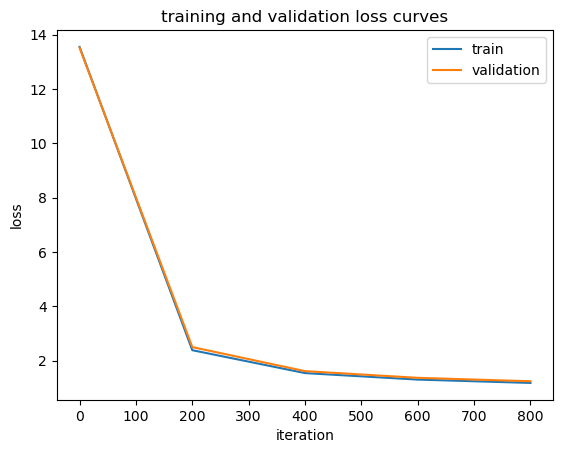

In [24]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, train_losses, label='train')
plt.plot(iters, val_losses, label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('training and validation loss curves')
plt.legend()
plt.show()

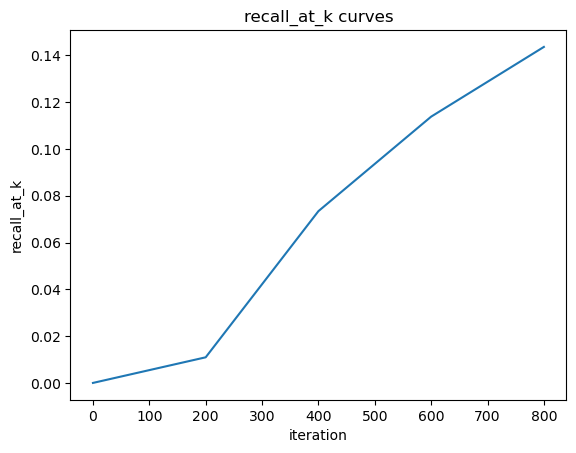

In [25]:
f2 = plt.figure()
plt.plot(iters, val_recall_at_ks, label='recall_at_k')
plt.xlabel('iteration')
plt.ylabel('recall_at_k')
plt.title('recall_at_k curves')
plt.show()

# Evaluation (RMSE)

In [26]:
def ndcg_at_k(y_true, y_reco, k):
    common_items, _, indices_in_reco = np.intersect1d(
        y_true, y_reco, assume_unique=True, return_indices=True
    )
    if common_items.size == 0:
        return 0
    rank_list = np.zeros(k, np.float32)
    rank_list[indices_in_reco] = 1
    ideal_list = np.sort(rank_list)[::-1]
    dcg = np.sum(rank_list / np.log2(np.arange(2, k + 2)))
    idcg = np.sum(ideal_list / np.log2(np.arange(2, k + 2)))
    return dcg / idcg

In [27]:
model.eval()
with torch.no_grad():
    pred_ratings = model.forward(test_edge_index, test_edge_values)
    recall_at_k, precision_at_k = get_recall_at_k(r_mat_test_edge_index, 
                                                  r_mat_test_edge_values, 
                                                  pred_ratings, 20)
    print(f"recall_at_k {round(recall_at_k, 5)}, precision_at_k {round(precision_at_k, 5)}")
    ndgc = ndcg_at_k(pred_ratings,r_mat_test_edge_values, pred_ratings.size(0))
    
    
print(f'NDGC: {ndgc}')


recall_at_k 0.16002, precision_at_k 0.41394
NDGC: 0.9974971350586624


In [28]:
print(test_edge_index)

model.forward(test_edge_index[0].item(), test_edge_values[0].item())

tensor([[    0,     0,     0,  ..., 10302, 10307, 10310],
        [  656,   734,   746,  ...,   513,   211,   337]])


RuntimeError: a Tensor with 19894 elements cannot be converted to Scalar

In [ ]:
# 1. Preparación
model.eval()

# Supongamos que quieres predecir las valoraciones de un conjunto de interacciones definido por edge_index_pred y edge_values_pred
edge_index_pred = edge_index_pred.to(device)
edge_values_pred = edge_values_pred.to(device)

# 2. Hacer la predicción
predicted_ratings = model.forward(edge_index_pred, edge_values_pred)

# 3. Post-procesamiento (opcional)
# Por ejemplo, si quieres convertir las predicciones a una lista:
predicted_ratings_list = predicted_ratings.detach().cpu().numpy().tolist()

# Ahora, `predicted_ratings_list` contiene las valoraciones predichas para las interacciones definidas en `edge_index_pred`.


# NDGC